In [38]:
!pip install statsmodels
!pip install seaborn

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [39]:
%matplotlib inline

import os
import h5py
import pandas as pd
import numpy as np
import zipfile
import random
import time

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.proportion import proportion_confint
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import check_random_state
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_curve, auc, log_loss
from sklearn import metrics
from skimage import exposure
from scipy import ndimage

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model

print("TF  Version",tf.__version__)

TF  Version 2.4.0


In [40]:
# check and set path before loading modules
print(os.getcwd())
DIR = "/tf/notebooks/brdd/xAI_stroke_3d/"
if os.getcwd() != DIR:
    os.chdir(DIR)

import helper_functions as hlp
import function_model_definition as md
import function_read_data as rdat

/tf/notebooks/brdd/xAI_stroke_3d
TF  Version 2.4.0


#### Helpfull Links

for best Threshold:
https://towardsdatascience.com/optimal-threshold-for-imbalanced-classification-5884e870c293

for gradcam averaging:
https://towardsdatascience.com/understand-your-algorithm-with-grad-cam-d3b62fce353

## Load Data and Results

In [41]:
# Define Version (which splits and models)
version = "10Fold_sigmoid_V3" # one of the following (see ZZ_overview_of_runs.txt for details):
# 10Fold_sigmoid_V0, 10Fold_sigmoid_V1, 10Fold_sigmoid_V2, 10Fold_sigmoid_V2f, 10Fold_sigmoid_V3  
# 10Fold_softmax_V0, 10Fold_softmax_V1, andrea

# should csv be saved?
save_file = True

OUTPUT_DIR = DIR + "data/"

In [42]:
## 10 Fold
if version.startswith("10Fold"):
    # Define the path + output path:

    DATA_DIR = DIR + "data/"
    WEIGHT_DIR = DIR + "weights/" + version + "/"

    # load data
    if version.endswith("V0") or version.endswith("sigmoid"):
        id_tab = pd.read_csv(DATA_DIR + "10Fold_ids_V0.csv", sep=",")
    elif version.endswith("V1"):
        id_tab = pd.read_csv(DATA_DIR + "10Fold_ids_V1.csv", sep=",")
    elif version.endswith("V2") or version.endswith("V2f"):
        id_tab = pd.read_csv(DATA_DIR + "10Fold_ids_V2.csv", sep=",")
    elif version.endswith("V3"):
        id_tab = pd.read_csv(DATA_DIR + "10Fold_ids_V3.csv", sep=",")
    X = np.load(DATA_DIR + "prepocessed_dicom_3d.npy")

    # define save name
    all_result_name = "all_tab_results_" + version

    # define splits
    which_splits = list(range(0,10)) # 10 Fold

    print(id_tab.shape)
    print(X.shape)

    
## Andrea 6 Split
elif version == "andrea":
    # Define the path + output path:

    IMG_DIR = "/tf/notebooks/hezo/stroke_zurich/data/" 
    DATA_DIR = "/tf/notebooks/hezo/stroke_zurich/data/" 
    WEIGHT_DIR = DIR + "weights/andrea_split/"

    # define data paths
    img_path = IMG_DIR + 'dicom_2d_192x192x3_clean_interpolated_18_02_2021_preprocessed2.h5'
    tab_path = IMG_DIR + 'baseline_data_zurich_prepared.csv'
    split_path = DIR + 'data/andrea_splits.csv'

    # define save name
    all_result_name = "all_tab_results_andrea_split"

    # # define splits
    which_splits = list(range(1,7)) # Andrea


(295, 14)
(407, 128, 128, 28)


In [43]:
print(WEIGHT_DIR)
print(all_result_name)

/tf/notebooks/brdd/xAI_stroke_3d/weights/10Fold_sigmoid_V3/
all_tab_results_10Fold_sigmoid_V3


In [44]:
## define model numbers
if version in ["andrea", "10Fold_sigmoid_V0", "10Fold_softmax_V0", 
               "10Fold_sigmoid_V2", "10Fold_sigmoid_V2f", "10Fold_sigmoid_V3"]:
    model_nrs = list(range(10, 15))
elif version in ["10Fold_softmax_V1", "10Fold_sigmoid_V1"]:
    model_nrs = list(range(10,20))

# define model
input_dim = (128, 128, 28, 1)

if "sigmoid" in version or "andrea_split" in version:
    last_activation = "sigmoid"
    output_dim = 1
    LOSS = "binary_crossentropy"
elif "softmax" in version:
    last_activation = "softmax"
    output_dim = 2
    LOSS = tf.keras.losses.categorical_crossentropy
    
if version.endswith("f"):
    layer_connection = "flatten"
else:
    layer_connection = "globalAveragePooling"
    

model_3d = md.stroke_binary_3d(input_dim = input_dim,
                               output_dim = output_dim,
                               layer_connection = layer_connection,
                               last_activation = last_activation)
model_3d.compile(
    loss=LOSS,
    optimizer=keras.optimizers.Adam(learning_rate=5*1e-5),
    metrics=["acc", tf.keras.metrics.AUC()]
)

# define if print should be enabled
check_print = True
        

In [45]:
# Define model name
def generate_model_name(which_split, model_nr, path = WEIGHT_DIR):
    if layer_connection == "globalAveragePooling":
        return (path + "3d_cnn_binary_model_split" + str(which_split) + 
                  "_unnormalized_avg_layer_paper_model_" + last_activation + "_activation_" + str(model_nr) + ".h5")
    elif layer_connection == "flatten":
        return (path + "3d_cnn_binary_model_split" + str(which_split) + 
                  "_unnormalized_flat_layer_paper_model_" + last_activation + "_activation_" + str(model_nr) + ".h5")

In [46]:
results_list = [] # test dataset results
valid_list = [] # validation datset results

# loop over splits and models
start = time.time()
for which_split in which_splits:
    if check_print:
        print(" ")
        print("---- Start Reading Data of Split " + str(which_split) + " ----")
        print(" ")
    
    # 10 Fold
    if version.startswith("10Fold"):
        (X_train, X_valid, X_test), (y_train, y_valid, y_test) = rdat.split_data(id_tab, X, which_split)
        results = id_tab[id_tab["fold" + str(which_split)] == "test"].copy()
    
    # Andrea
    elif version == "andrea":
        (X_train, X_valid, X_test), (y_train, y_valid, y_test), results = rdat.read_and_split_img_data_andrea(
                path_img = img_path, 
                path_tab = tab_path, 
                path_splits = split_path, 
                split = which_split, 
                check_print = check_print)
           
    # add variable with current split
    results["test_split"] = which_split        
    
    # create new df for validation set, to calculate classification threshold 
    # => not cheating when calc on valid
    validation_results = pd.DataFrame(
        {"test_split": which_split,
         "unfavorable": y_valid}
    )
    
    if check_print:
        print(" ")
        print("---- Starting Result Calculation of Split " + str(which_split) + " ----")
        print(" ")
        
    y_test_preds = []
    y_valid_preds = []
     
    for model_nr in model_nrs:
        if check_print:
            print("Now calculating model nr. " + str(model_nr))
        
        model_3d.load_weights(generate_model_name(which_split, model_nr, WEIGHT_DIR))
        
        if last_activation == "softmax":
            y_test_preds.append(model_3d.predict(X_test)[:,1].squeeze())
        else:
            y_test_preds.append(model_3d.predict(X_test).squeeze())
        results["y_pred_model_" + str(model_nr)] = y_test_preds[-1]
        
        if last_activation == "softmax":
            y_valid_preds.append(model_3d.predict(X_valid)[:,1].squeeze())
        else:
            y_valid_preds.append(model_3d.predict(X_valid).squeeze())
        validation_results["y_pred_model_" + str(model_nr)] = y_valid_preds[-1]
    
    y_test_preds = np.array(y_test_preds)
    results["y_pred_linear_avg"] = np.mean(y_test_preds, axis = 0)
    results["y_pred_trafo_avg"] = hlp.sigmoid(np.mean(hlp.inverse_sigmoid(y_test_preds), axis = 0))
    
    y_valid_preds = np.array(y_valid_preds)
    validation_results["y_pred_linear_avg"] = np.mean(y_valid_preds, axis = 0)
    validation_results["y_pred_trafo_avg"] = hlp.sigmoid(np.mean(hlp.inverse_sigmoid(y_valid_preds), axis = 0))
        
    results_list.append(results)
    valid_list.append(validation_results)
        
if check_print:
    end = time.time()
    print(" ")
    print("---- DONE ----")
    print(" ")   
    print("Duration of Execution: " + str(end-start))               
        

 
---- Start Reading Data of Split 0 ----
 
 
---- Starting Result Calculation of Split 0 ----
 
Now calculating model nr. 10
Now calculating model nr. 11
Now calculating model nr. 12
Now calculating model nr. 13
Now calculating model nr. 14
 
---- Start Reading Data of Split 1 ----
 
 
---- Starting Result Calculation of Split 1 ----
 
Now calculating model nr. 10
Now calculating model nr. 11
Now calculating model nr. 12
Now calculating model nr. 13
Now calculating model nr. 14
 
---- Start Reading Data of Split 2 ----
 
 
---- Starting Result Calculation of Split 2 ----
 
Now calculating model nr. 10
Now calculating model nr. 11
Now calculating model nr. 12
Now calculating model nr. 13
Now calculating model nr. 14
 
---- Start Reading Data of Split 3 ----
 
 
---- Starting Result Calculation of Split 3 ----
 
Now calculating model nr. 10
Now calculating model nr. 11
Now calculating model nr. 12
Now calculating model nr. 13
Now calculating model nr. 14
 
---- Start Reading Data of Spl

## Calculate Threshold

Calculation of threshold for classification is done on validation data. Then applied to the test data.

In [47]:
# should threshold be calculated per split or over all?

 
---- Split 0 ----
 
Optimal Geometric Mean Threshold: 0.10905089
Accuracy to beat: 0.7586206896551724
Accuracy: 0.7586206896551724
Spezifität:  0.6818181818181819
Sensitivität:  1.0


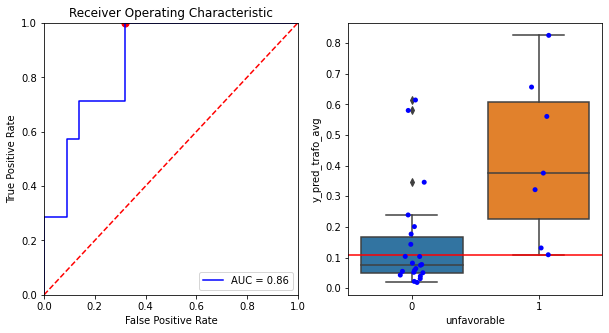

 
---- Split 1 ----
 
Optimal Geometric Mean Threshold: 0.35052162
Accuracy to beat: 0.7586206896551724
Accuracy: 0.8275862068965517
Spezifität:  0.8636363636363636
Sensitivität:  0.7142857142857143


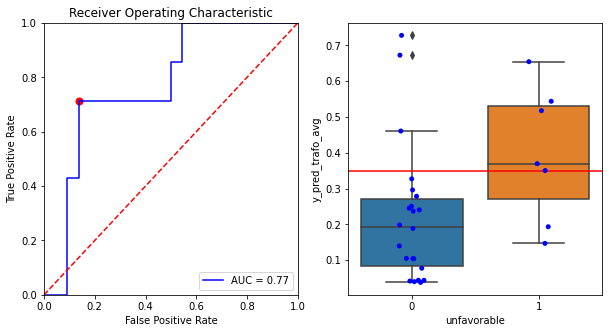

 
---- Split 2 ----
 
Optimal Geometric Mean Threshold: 0.33056244
Accuracy to beat: 0.7586206896551724
Accuracy: 0.7241379310344828
Spezifität:  0.7272727272727273
Sensitivität:  0.7142857142857143


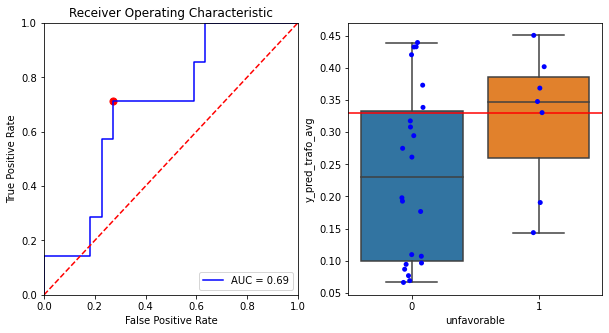

 
---- Split 3 ----
 
Optimal Geometric Mean Threshold: 0.28388903
Accuracy to beat: 0.7586206896551724
Accuracy: 0.6896551724137931
Spezifität:  0.6818181818181819
Sensitivität:  0.7142857142857143


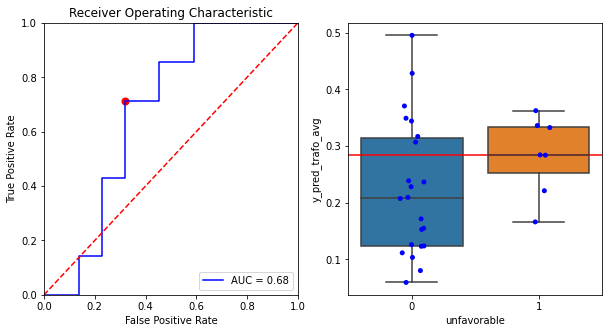

 
---- Split 4 ----
 
Optimal Geometric Mean Threshold: 0.1653997
Accuracy to beat: 0.7586206896551724
Accuracy: 0.7241379310344828
Spezifität:  0.6818181818181819
Sensitivität:  0.8571428571428571


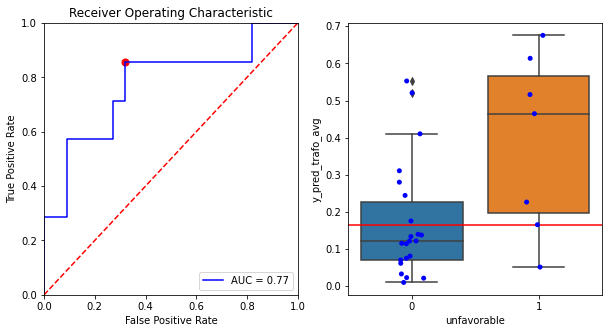

 
---- Split 5 ----
 
Optimal Geometric Mean Threshold: 0.2971011
Accuracy to beat: 0.7666666666666666
Accuracy: 0.8333333333333334
Spezifität:  0.9130434782608696
Sensitivität:  0.5714285714285714


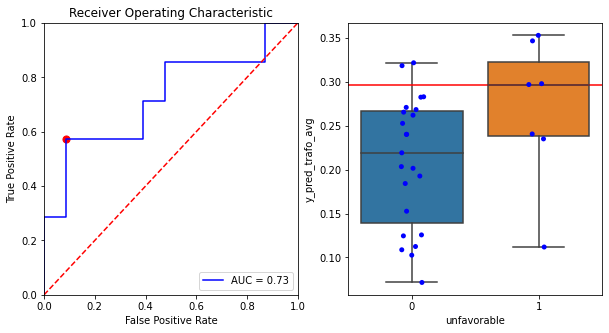

 
---- Split 6 ----
 
Optimal Geometric Mean Threshold: 0.2577261
Accuracy to beat: 0.7666666666666666
Accuracy: 0.6333333333333333
Spezifität:  0.6086956521739131
Sensitivität:  0.7142857142857143


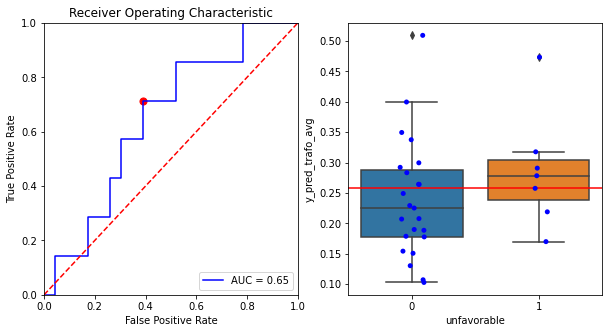

 
---- Split 7 ----
 
Optimal Geometric Mean Threshold: 0.246659
Accuracy to beat: 0.7666666666666666
Accuracy: 0.7666666666666667
Spezifität:  0.7391304347826086
Sensitivität:  0.8571428571428571


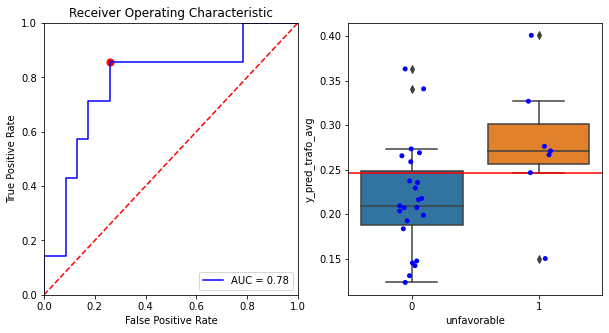

 
---- Split 8 ----
 
Optimal Geometric Mean Threshold: 0.2444555
Accuracy to beat: 0.7666666666666666
Accuracy: 0.7333333333333333
Spezifität:  0.8695652173913043
Sensitivität:  0.2857142857142857


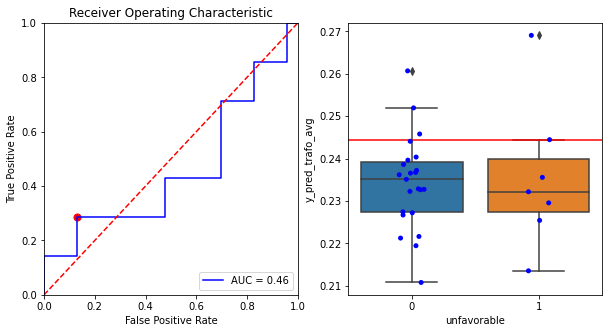

 
---- Split 9 ----
 
Optimal Geometric Mean Threshold: 0.25683388
Accuracy to beat: 0.7666666666666666
Accuracy: 0.8
Spezifität:  0.782608695652174
Sensitivität:  0.8571428571428571


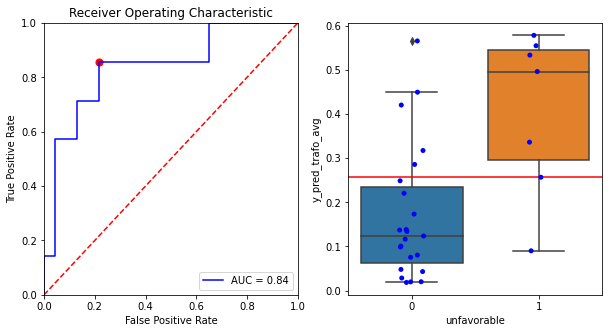

In [48]:
valid_thresholds = []

for i, validation_results in enumerate(valid_list):
    print(" ")
    print("---- Split " + str(which_splits[i]) + " ----")
    print(" ")
    
    y_org = validation_results["unfavorable"]
    y_pred = validation_results["y_pred_trafo_avg"]
    
    # calculate fpr, tpr and thresholds
    fpr, tpr, threshold = metrics.roc_curve(y_org, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    # calculate geometric mean of tpr and fpr to find best threshold
    gmean = np.sqrt(tpr * (1 - fpr))

    # Find the optimal threshold
    index = np.argmax(gmean)
    valid_thresholds.append(threshold[index])
    print("Optimal Geometric Mean Threshold: " + str(threshold[index]))
    
    # Calc Acc
    y_pred_label = (y_pred >= threshold[index]).squeeze()
    print("Accuracy to beat: " + str(1 - np.mean(y_org)))
    print("Accuracy: " + str(np.mean(y_pred_label == y_org)))
          
    print("Spezifität: ", 1-fpr[index])
    print("Sensitivität: ", tpr[index])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
    
    # method I: plt
    ax1.title.set_text('Receiver Operating Characteristic')
    ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    ax1.scatter(fpr[index], tpr[index], color = "red", s = 50)
    ax1.legend(loc = 'lower right')
    ax1.plot([0, 1], [0, 1],'r--')
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    ax1.set_ylabel('True Positive Rate')
    ax1.set_xlabel('False Positive Rate')
    
    sns.boxplot(x = "unfavorable",
        y = "y_pred_trafo_avg",
        data = validation_results,
        ax = ax2)
    sns.stripplot(x = "unfavorable",
        y = "y_pred_trafo_avg",
        color = 'blue',
        data = validation_results,
        ax = ax2)
    ax2.axhline(y = threshold[index], color = "red")
    
    plt.show()

In [49]:
valid_thresholds

[0.10905089,
 0.35052162,
 0.33056244,
 0.28388903,
 0.1653997,
 0.2971011,
 0.2577261,
 0.246659,
 0.2444555,
 0.25683388]

### Apply Threshold to Testdata

 
---- Split 0 ----
 
Accuracy to beat: 0.7666666666666666
Accuracy: 0.5333333333333333
Spezifität:  0.4782608695652174
Sensitivität:  0.7142857142857143


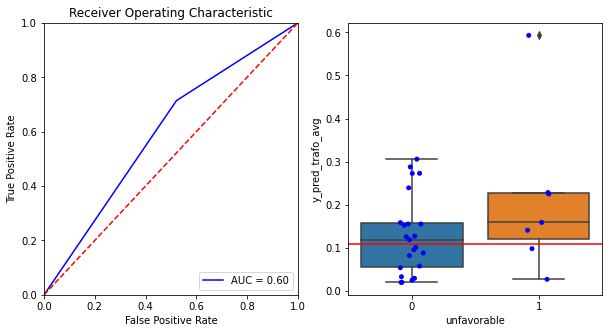

 
---- Split 1 ----
 
Accuracy to beat: 0.7666666666666666
Accuracy: 0.7333333333333333
Spezifität:  0.9130434782608696
Sensitivität:  0.14285714285714285


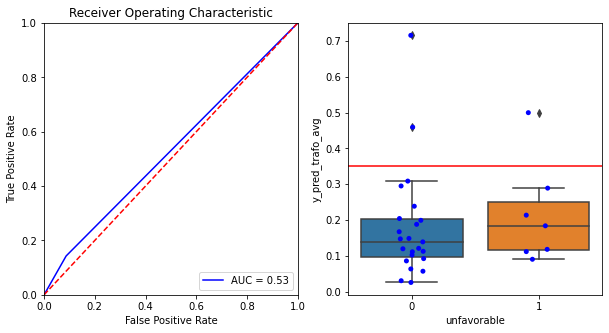

 
---- Split 2 ----
 
Accuracy to beat: 0.7666666666666666
Accuracy: 0.6333333333333333
Spezifität:  0.7391304347826086
Sensitivität:  0.2857142857142857


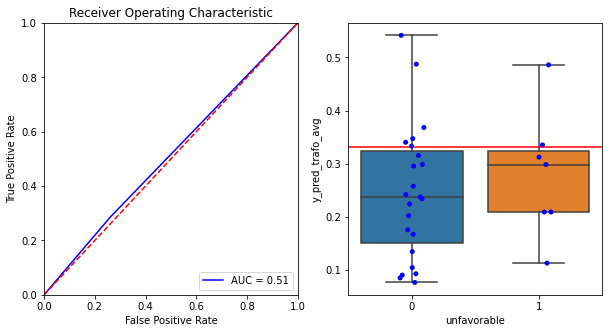

 
---- Split 3 ----
 
Accuracy to beat: 0.7666666666666666
Accuracy: 0.5666666666666667
Spezifität:  0.6086956521739131
Sensitivität:  0.42857142857142855


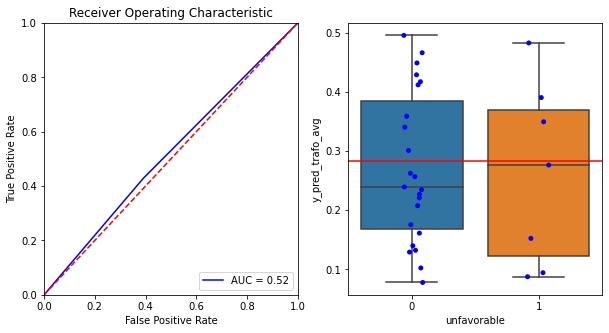

 
---- Split 4 ----
 
Accuracy to beat: 0.7666666666666666
Accuracy: 0.6333333333333333
Spezifität:  0.6086956521739131
Sensitivität:  0.7142857142857143


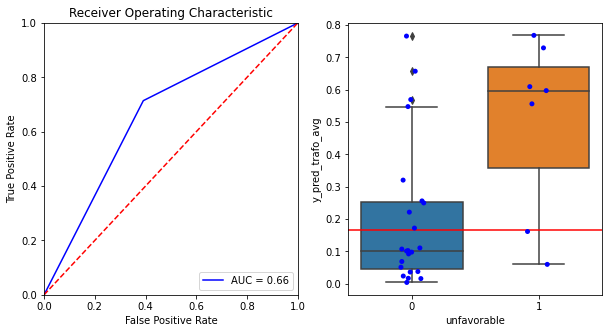

 
---- Split 5 ----
 
Accuracy to beat: 0.7586206896551724
Accuracy: 0.7586206896551724
Spezifität:  0.8181818181818181
Sensitivität:  0.5714285714285714


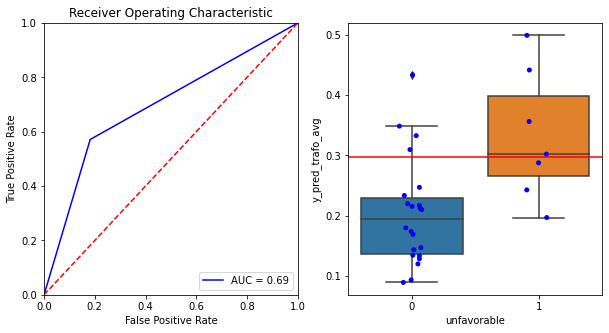

 
---- Split 6 ----
 
Accuracy to beat: 0.7586206896551724
Accuracy: 0.5862068965517241
Spezifität:  0.5454545454545454
Sensitivität:  0.7142857142857143


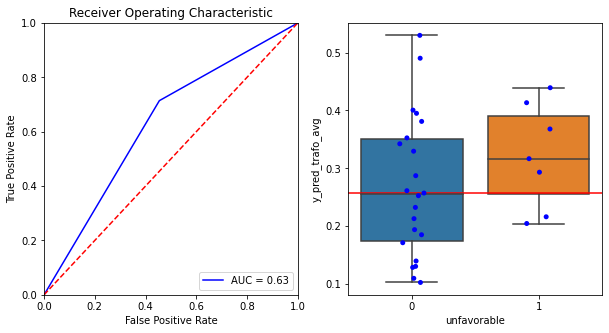

 
---- Split 7 ----
 
Accuracy to beat: 0.7586206896551724
Accuracy: 0.6206896551724138
Spezifität:  0.5909090909090908
Sensitivität:  0.7142857142857143


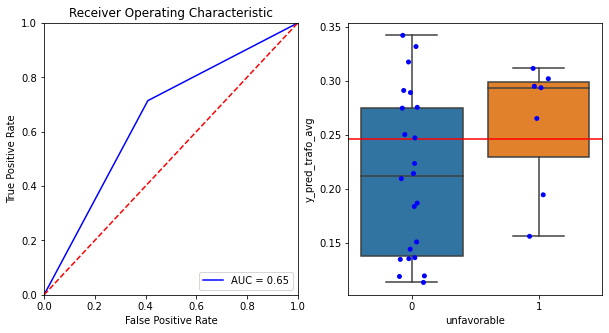

 
---- Split 8 ----
 
Accuracy to beat: 0.7586206896551724
Accuracy: 0.6896551724137931
Spezifität:  0.7272727272727273
Sensitivität:  0.5714285714285714


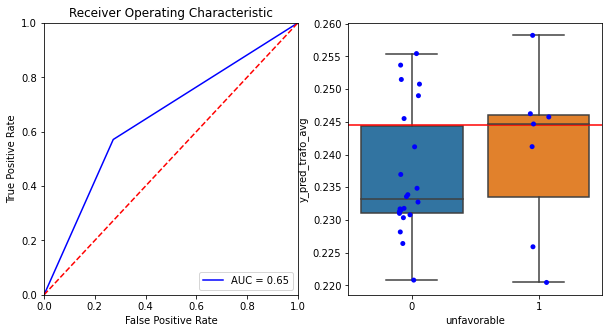

 
---- Split 9 ----
 
Accuracy to beat: 0.7586206896551724
Accuracy: 0.7586206896551724
Spezifität:  0.8181818181818181
Sensitivität:  0.5714285714285714


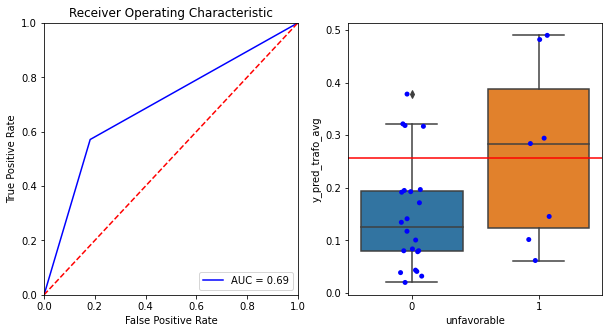

In [50]:
for i, results in enumerate(results_list):
    print(" ")
    print("---- Split " + str(which_splits[i]) + " ----")
    print(" ")

    results["threshold"] = valid_thresholds[i]
    results["y_pred_class"] = (results["y_pred_trafo_avg"] >= results["threshold"]).astype(int)
    
    y_org = results["unfavorable"]
    y_pred = results["y_pred_class"]
    
    # calculate fpr, tpr and thresholds
    fpr, tpr, threshold = metrics.roc_curve(y_org, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
      
    # Calc Acc
    print("Accuracy to beat: " + str(1 - np.mean(y_org)))
    print("Accuracy: " + str(np.mean(y_pred == y_org)))
          
    print("Spezifität: ", 1-fpr[1])
    print("Sensitivität: ", tpr[1])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
    
    # method I: plt
    ax1.title.set_text('Receiver Operating Characteristic')
    ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    ax1.legend(loc = 'lower right')
    ax1.plot([0, 1], [0, 1],'r--')
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    ax1.set_ylabel('True Positive Rate')
    ax1.set_xlabel('False Positive Rate')
    
    sns.boxplot(x = "unfavorable",
        y = "y_pred_trafo_avg",
        data = results,
        ax = ax2)
    sns.stripplot(x = "unfavorable",
        y = "y_pred_trafo_avg",
        color = 'blue',
        data = results,
        ax = ax2)
    ax2.axhline(y = valid_thresholds[i], color = "red")
    
    plt.show()

#### Concat all Pandas and Analyze

In [51]:
all_results = pd.concat(results_list)
all_results.shape

(295, 24)

Accuracy to beat: 0.7627118644067796
Accuracy: 0.6508474576271186
Spezifität:  0.6844444444444444
Sensitivität:  0.5428571428571428


<AxesSubplot:xlabel='unfavorable', ylabel='y_pred_trafo_avg'>

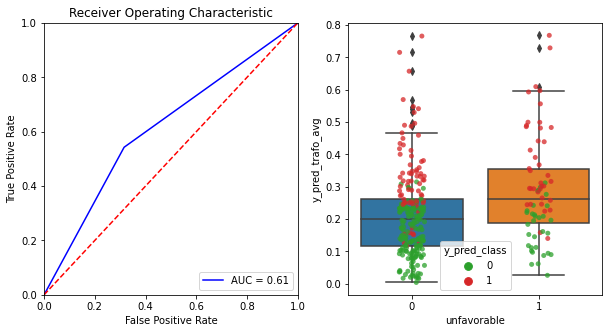

In [52]:
y_org = all_results["unfavorable"]
y_pred = all_results["y_pred_class"]

# calculate fpr, tpr and thresholds
fpr, tpr, threshold = metrics.roc_curve(y_org, y_pred)
roc_auc = metrics.auc(fpr, tpr)

# Calc Acc
y_pred_label = all_results["y_pred_class"]
print("Accuracy to beat: " + str(1 - np.mean(y_org)))
print("Accuracy: " + str(np.mean(y_pred_label == y_org)))

print("Spezifität: ", 1-fpr[1])
print("Sensitivität: ", tpr[1])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

# method I: plt
ax1.title.set_text('Receiver Operating Characteristic')
ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax1.legend(loc = 'lower right')
ax1.plot([0, 1], [0, 1],'r--')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')

sns.boxplot(x = "unfavorable",
    y = "y_pred_trafo_avg",
    data = all_results,
    ax = ax2)
sns.stripplot(x = "unfavorable",
    y = "y_pred_trafo_avg",
    hue = 'y_pred_class',
    palette=["C2", "C3", "k"],
    data = all_results,
    alpha = 0.75,
    ax = ax2)
    

## Calculation of one threshold

threshold:  0.24078144
Accuracy to beat: 0.7627118644067796
Accuracy: 0.688135593220339
Spezifität:  0.6888888888888889
Sensitivität:  0.6857142857142857


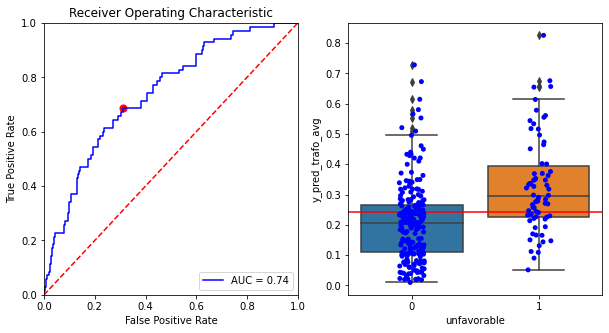

In [53]:
all_valid_results = pd.concat(valid_list)

y_org = all_valid_results["unfavorable"]
y_pred = all_valid_results["y_pred_trafo_avg"]

fpr, tpr, threshold = metrics.roc_curve(y_org, y_pred)
roc_auc = metrics.auc(fpr, tpr)

# calculate geometric mean of tpr and fpr to find best threshold
gmean = np.sqrt(tpr * (1 - fpr))

# Find the optimal threshold
index = np.argmax(gmean)
valid_threshold = threshold[index]
print("threshold: ", threshold[index])


y_pred_label = (y_pred >= threshold[index]).squeeze()
print("Accuracy to beat: " + str(1 - np.mean(y_org)))
print("Accuracy: " + str(np.mean(y_pred_label == y_org)))

print("Spezifität: ", 1-fpr[index])
print("Sensitivität: ", tpr[index])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

# method I: plt
ax1.title.set_text('Receiver Operating Characteristic')
ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax1.scatter(fpr[index], tpr[index], color = "red", s = 50)
ax1.legend(loc = 'lower right')
ax1.plot([0, 1], [0, 1],'r--')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')

sns.boxplot(x = "unfavorable",
    y = "y_pred_trafo_avg",
    data = all_valid_results,
    ax = ax2)
sns.stripplot(x = "unfavorable",
    y = "y_pred_trafo_avg",
    color = 'blue',
    data = all_valid_results,
    ax = ax2)
ax2.axhline(y = threshold[index], color = "red")

Accuracy to beat:     0.7627
Accuracy:             0.6508
-----------------[95% Conf.]-----------------
AUC of probabilities: 0.6505 [0.5761 0.7186]
NLL :                 0.5278
Threshold:            0.2408
Spezifität:           0.6711 [0.6073 0.7292]
Sensitivität:         0.5857 [0.4688 0.6937]


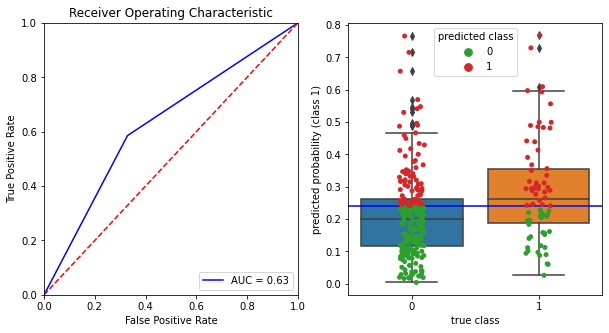

In [54]:
all_results["threshold2"] = valid_threshold
all_results["y_pred_class2"] = (all_results["y_pred_trafo_avg"] >= all_results["threshold2"]).astype(int)

y_org = all_results["unfavorable"]
y_pred = all_results["y_pred_class2"]
y_pred_prob = all_results["y_pred_trafo_avg"]

# calculate fpr and tpr for probabilities
fpr_prob, tpr_prob, thresholds_prob = metrics.roc_curve(y_org, y_pred_prob)

# calculate fpr, tpr and thresholds for class
fpr, tpr, threshold = metrics.roc_curve(y_org, y_pred)
roc_auc = metrics.auc(fpr, tpr)

# calculate AUC confint
AUC0_CI = hlp.compute_auc_ci(y_org, y_pred_prob)

# calculate spez and sens confint
cm = confusion_matrix(y_org, y_pred)
# sens
nobs = sum([cm[1,0],cm[1,1]])
count = sum([cm[1,1]])
sens_ci_low, sens_ci_upp = proportion_confint(count , nobs,  alpha=0.05, method='wilson')
#spec 
nobs = sum([cm[0,1],cm[0,0]])
count = sum([cm[0,0]])
spec_ci_low, spec_ci_upp = proportion_confint(count , nobs,  alpha=0.05, method='wilson')

# Calc Acc
print("Accuracy to beat:     " + str(round(1 - np.mean(y_org), 4)))
print("Accuracy:             " + str(round(np.mean(y_pred == y_org), 4)))
print("-----------------[95% Conf.]-----------------")

print("AUC of probabilities: " + str(round(metrics.auc(fpr_prob, tpr_prob), 4)) + " " +
                                 str(np.around([AUC0_CI[0], AUC0_CI[1]],4)))
print("NLL :                 " + str(round(metrics.log_loss(y_org, y_pred_prob), 4)))

print("Threshold:            " + str(round(valid_threshold, 4)))

print("Spezifität:           " + str(round(1-fpr[1], 4)) + " " +
                                 str(np.around([spec_ci_low, spec_ci_upp],4)))
print("Sensitivität:         " + str(round(tpr[1], 4)) + " " +
                                 str(np.around([sens_ci_low, sens_ci_upp],4)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

# method I: plt
ax1.title.set_text('Receiver Operating Characteristic')
ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax1.legend(loc = 'lower right')
ax1.plot([0, 1], [0, 1],'r--')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')

sns.boxplot(x = "unfavorable",
    y = "y_pred_trafo_avg",
    data = all_results,
    ax = ax2)
sns.stripplot(x = "unfavorable",
    y = "y_pred_trafo_avg",
    hue = 'y_pred_class2',
    palette=["C2", "C3"],
    data = all_results,
    ax = ax2)
plt.legend(title='predicted class', loc='upper center')
ax2.set(xlabel='true class', ylabel='predicted probability (class 1)')
ax2.axhline(y = valid_threshold, color = "blue")

In [55]:
all_results

,p_idx,p_id,mrs,unfavorable,fold0,fold1,fold2,fold3,fold4,fold5,...,y_pred_model_11,y_pred_model_12,y_pred_model_13,y_pred_model_14,y_pred_linear_avg,y_pred_trafo_avg,threshold,y_pred_class,threshold2,y_pred_class2
4,5,6,3.0,1,test,train,train,train,train,val,...,0.153151,0.316242,0.210725,0.228032,0.228860,0.224606,0.109051,1,0.240781,0
14,15,22,0.0,0,test,train,train,train,train,val,...,0.091951,0.171828,0.103543,0.164491,0.128567,0.125061,0.109051,1,0.240781,0
22,23,32,0.0,0,test,train,train,train,train,val,...,0.302507,0.283601,0.226451,0.285313,0.273201,0.272381,0.109051,1,0.240781,1
30,31,41,0.0,0,test,train,train,train,train,val,...,0.025152,0.159836,0.043219,0.049839,0.068522,0.056944,0.109051,0,0.240781,0
34,35,46,0.0,0,test,train,train,train,train,val,...,0.010369,0.042215,0.020538,0.014279,0.021617,0.019314,0.109051,0,0.240781,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,356,498,1.0,0,train,train,train,train,val,train,...,0.037785,0.033572,0.025475,0.031230,0.032378,0.032119,0.256834,0,0.240781,0
260,362,505,2.0,0,train,train,train,train,val,train,...,0.037770,0.041579,0.040650,0.060009,0.044121,0.043516,0.256834,0,0.240781,0
265,367,510,4.0,1,train,train,train,train,val,train,...,0.099050,0.090400,0.093739,0.127865,0.102370,0.101675,0.256834,0,0.240781,0
275,377,521,0.0,0,train,train,train,train,val,train,...,0.078537,0.066687,0.074634,0.090140,0.080999,0.080398,0.256834,0,0.240781,0


## Calculate Model Uncertainty

In [56]:
all_results["y_pred_std"] = all_results[["y_pred_model_1" + str(i) for i in range(5)]].std(axis = 1)
all_results["y_pred_unc"] = (all_results["y_pred_std"] - all_results.y_pred_std.min()) / (
    all_results.y_pred_std.max() - all_results.y_pred_std.min())

[Text(0.5, 0, 'true class'), Text(0, 0.5, 'prediction uncertainty')]

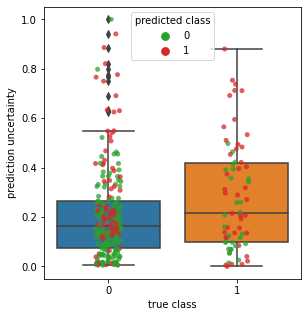

In [57]:
# Plot uncertainty
plt.figure(figsize = (4.6,5))
sns.boxplot(x = "unfavorable",
    y = "y_pred_unc",
    data = all_results)
g = sns.stripplot(x = "unfavorable",
    y = "y_pred_unc",
    hue = 'y_pred_class2',
    alpha = 0.75,
    palette=["C2", "C3"],
    data = all_results)
plt.legend(title='predicted class', loc='upper center')
g.set(xlabel='true class', ylabel='prediction uncertainty')

<AxesSubplot:xlabel='pred_correct', ylabel='y_pred_unc'>

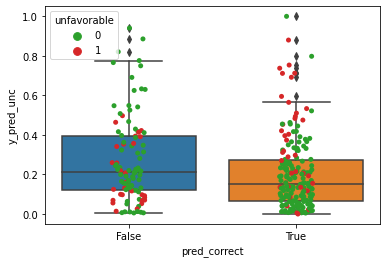

In [58]:
all_results["pred_correct"] = all_results["y_pred_class2"] == all_results["unfavorable"] 

sns.boxplot(x = "pred_correct",
    y = "y_pred_unc",
    data = all_results)
sns.stripplot(x = "pred_correct",
    y = "y_pred_unc",
    hue = 'unfavorable',
    palette=["C2", "C3"],
    data = all_results)

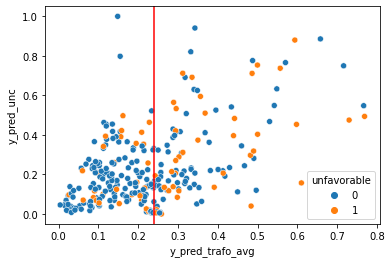

In [79]:
sns.scatterplot(
           x = "y_pred_trafo_avg",
           y = "y_pred_unc",
           hue = "unfavorable",
           data = all_results)
plt.axvline(x = valid_threshold, color = "red")

### Save results

Delete threshold 1 because mulitple different thresholds does not make sense.

In [60]:
all_results = all_results.drop(columns = ["y_pred_class", "threshold"])
all_results = all_results.rename(columns = {"y_pred_class2": "y_pred_class", "threshold2": "threshold"})

In [61]:
if save_file:
    all_results.to_csv(OUTPUT_DIR + all_result_name + ".csv",  index=False) # rename output file!!!!

# Check Splits

Only used for andreas/paper split

In [62]:
if version == "andrea":    
    andrea_splits = pd.read_csv(split_path, 
                                    sep='\,', header = None, engine = 'python', 
                                    usecols = [1,2,3]).apply(lambda x: x.str.replace(r"\"",""))
    andrea_splits.columns = andrea_splits.iloc[0]
    andrea_splits.drop(index=0, inplace=True)
    andrea_splits = andrea_splits.astype({'idx': 'int32', 'spl': 'int32'})
    print(andrea_splits[andrea_splits["type"].isin(["test"])].idx.nunique())
    print(sum(andrea_splits["type"].isin(["test"])))

In [63]:
if version == "andrea":
    all_p_dup = all_results[all_results["p_id"].duplicated()]["p_id"].unique()
    all_dup = all_results[all_results["p_id"].isin(all_p_dup)].sort_values("p_id")
    all_dup["p_id"].value_counts().value_counts()

In [64]:
if version == "andrea":
    print("Total duplicate: ", len(all_dup["p_id"].value_counts()))

    print("gleich klassifieziert (%): ", np.mean(all_dup.groupby("p_id").y_pred_class.mean().isin([0,1])))
    print("gleich klassifieziert (abs): ", np.sum(all_dup.groupby("p_id").y_pred_class.mean().isin([0,1])))

In [65]:
if version == "andrea":
    sns.histplot(all_dup.groupby("p_id").y_pred_trafo_avg.std())

In [66]:
if version == "andrea":
    all_dup

## Calibration Plot

In [67]:
cal_plot_datas = []
for split in which_splits:
    dat = all_results.loc[all_results["test_split"] == split]
    cal_plot_datas.append(hlp.cal_plot_data_prep(
        dat["y_pred_trafo_avg"].array, dat["unfavorable"].array
    ).select_dtypes(include=np.number))

In [68]:
all_cal_plot_datas = pd.concat(cal_plot_datas)
all_cal_plot_datas["iter"] = all_cal_plot_datas.index
all_cal_plot_datas = all_cal_plot_datas.groupby("iter")[
    ["predicted_probability_middle", "observed_proportion", "observed_proportion_lower", "observed_proportion_upper"]].mean()

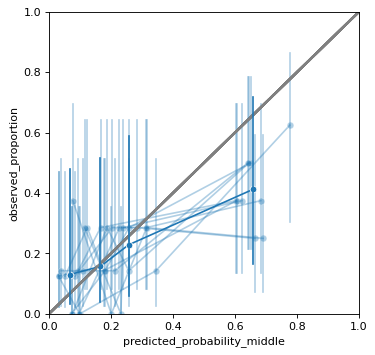

In [69]:
from matplotlib.pyplot import figure
figure(figsize=(5, 5), dpi=80)

for i in range(len(which_splits)):
    hlp.cal_plot(cal_plot_datas[i], 
             "predicted_probability_middle", "observed_proportion",
                        "observed_proportion_lower", "observed_proportion_upper", alpha = .35, show = False)
hlp.cal_plot(all_cal_plot_datas, "predicted_probability_middle", "observed_proportion",
                        "observed_proportion_lower", "observed_proportion_upper")

## Check Volume index

check if X_test and when selected via p_idx is same => for grad cams, because we have to get volume

In [70]:
with h5py.File("/tf/notebooks/hezo/stroke_zurich/data/dicom_2d_192x192x3_clean_interpolated_18_02_2021_preprocessed2.h5", "r") as h5:
# both images are the same
    X_in = h5["X"][:]
    Y_img = h5["Y_img"][:]
    Y_pat = h5["Y_pat"][:]
    pat = h5["pat"][:]

In [71]:
index = 0
results.p_id.array[0]

8

In [72]:
np.argwhere(pat == results.p_id.array[index]).squeeze()

array(5)

In [73]:
im1 = X_test[index].astype("float64")
im2 = X_in[np.argwhere(pat == results.p_id.array[index]).squeeze()].astype("float64")
np.allclose(im1, im2)

True

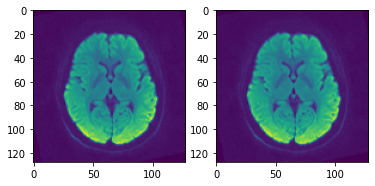

In [74]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(im1[:,:,14])
ax2.imshow(im2[:,:,14])